In [13]:
%%time

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Grid and time parameters
N = 100          # Grid size
dx = 0.2         # Spatial step size
dt = 0.05        # Time step size (keep small for stability with stronger forces)
n_steps = 30*15     # Enough steps to see the tornado spin
k = 8.0         # Coulomb interaction strength (positive, attraction handled by - sign)
epsilon = 0.2    # Regularization parameter to avoid singularity


# Masses for particles
m_1 = 1.0        # Mass of particle 1 (electron-like)
m_2 = 1800.0     # Mass of particle 2 (proton-like, ~1836 times heavier)

# Particle 1: Starts closer to center, spinning faster (electron-like)
x0_1, y0_1 = 6, 0   # Initial position
px_1, py_1 = 0, 0    # Initial momentum for spin
sigma_1 = 1.0            # Gaussian width

# Particle 2: Opposite side, mirroring the spin (proton-like)
x0_2, y0_2 = 0.0, 0.0    # Initial position
px_2, py_2 = 0, 0  # Opposite momentum for symmetry
sigma_2 = 0.25            # Same width

# Define 1D spatial grid
x = jnp.arange(-N // 2, N // 2) * dx

# Create 4D real-space grid: (x1, y1, x2, y2)
X1, Y1, X2, Y2 = jnp.meshgrid(x, x, x, x, indexing='ij')

# Initial wave function components
psi_1 = jnp.exp(-((X1 - x0_1)**2 + (Y1 - y0_1)**2) / (2 * sigma_1**2)) * \
        jnp.exp(1j * (px_1 * X1 + py_1 * Y1))
psi_2 = jnp.exp(-((X2 - x0_2)**2 + (Y2 - y0_2)**2) / (2 * sigma_2**2)) * \
        jnp.exp(1j * (px_2 * X2 + py_2 * Y2))

# Construct joint wave function and normalize
psi = psi_1 * psi_2
psi /= jnp.sqrt(jnp.sum(jnp.abs(psi)**2) * dx**4)

# Clear intermediate arrays from memory
del psi_1, psi_2

# Define potentials
# Weak harmonic potential to keep them dancing together
V_ext = 0.00 * (X1**2 + Y1**2 + X2**2 + Y2**2)  # Small coefficient for gentle trapping

r_squared = (X1 - X2)**2 + (Y1 - Y2)**2 + epsilon**2
V_int = -k / jnp.sqrt(r_squared)  # Attractive Coulomb potential

V = V_ext + V_int

# Define momentum grids and kinetic phases
kx = 2 * jnp.pi * jnp.fft.fftfreq(N, dx)
ky = 2 * jnp.pi * jnp.fft.fftfreq(N, dx)
KX, KY = jnp.meshgrid(kx, ky, indexing='ij')
# Kinetic phase for particle 1: exp(-i (kx^2 + ky^2) dt / (2 m_1))
phi_T1 = jnp.exp(-1j * (KX**2 + KY**2) * dt / (2 * m_1))  # Shape (N, N)
# Kinetic phase for particle 2: exp(-i (kx^2 + ky^2) dt / (2 m_2))
phi_T2 = jnp.exp(-1j * (KX**2 + KY**2) * dt / (2 * m_2))  # Shape (N, N)

# Split-step function for two-particle time evolution with masses
@jax.jit
def split_step_two_particle(psi, V, phi_T1, phi_T2):
    # Half kinetic step for particle 1: FFT over (x1, y1)
    psi_k1 = jnp.fft.fft2(psi, axes=(0, 1))
    psi_k1 *= phi_T1[..., None, None]  # Broadcast over x2, y2
    psi = jnp.fft.ifft2(psi_k1, axes=(0, 1))

    # Half kinetic step for particle 2: FFT over (x2, y2)
    psi_k2 = jnp.fft.fft2(psi, axes=(2, 3))
    psi_k2 *= phi_T2[None, None, :, :]  # Broadcast over x1, y1
    psi = jnp.fft.ifft2(psi_k2, axes=(2, 3))

    # Full potential step in position space
    psi *= jnp.exp(-1j * V * dt)

    # Half kinetic step for particle 2
    psi_k2 = jnp.fft.fft2(psi, axes=(2, 3))
    psi_k2 *= phi_T2[None, None, :, :]
    psi = jnp.fft.ifft2(psi_k2, axes=(2, 3))

    # Half kinetic step for particle 1
    psi_k1 = jnp.fft.fft2(psi, axes=(0, 1))
    psi_k1 *= phi_T1[..., None, None]
    psi = jnp.fft.ifft2(psi_k1, axes=(0, 1))

    return psi

# Time evolution loop with norm tracking and density history
rho1_history = []  # List to store particle 1's density
rho2_history = []  # List to store particle 2's density
n_save = 1         # Save every n_save steps

for t in range(n_steps):
    psi = split_step_two_particle(psi, V, phi_T1, phi_T2)  # Update psi with masses
    if t % n_save == 0:
        # Compute |ψ|^2
        psi_sq = jnp.abs(psi)**2  # Shape (N, N, N, N)
        
        # Particle 1’s marginal density: sum over x2 and y2 (axes 2 and 3)
        rho1 = jnp.sum(psi_sq, axis=(2, 3)) * dx**2  # Shape (N, N)
        
        # Particle 2’s marginal density: sum over x1 and y1 (axes 0 and 1)
        rho2 = jnp.sum(psi_sq, axis=(0, 1)) * dx**2  # Shape (N, N)
        
        # Save to CPU memory as NumPy arrays
        rho1_history.append(np.array(rho1))
        rho2_history.append(np.array(rho2))

CPU times: user 1.62 s, sys: 695 ms, total: 2.32 s
Wall time: 55.7 s


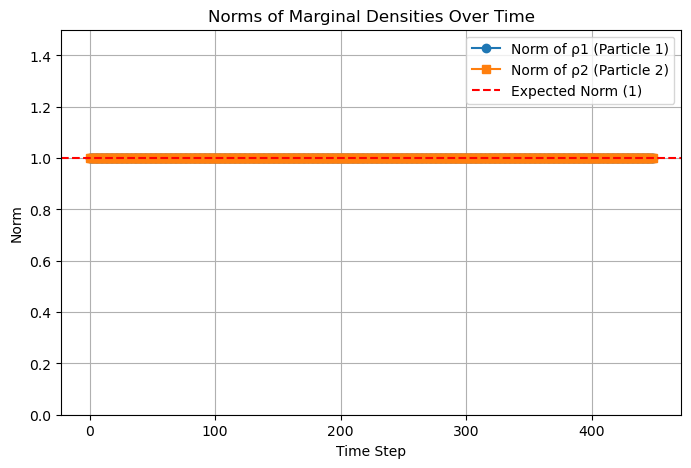

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Compute norms of ρ1 and ρ2 at each saved time step
# ρ1 norm = ∫ ρ1 dx1 dy1 ≈ sum(ρ1) * dx^2
# ρ2 norm = ∫ ρ2 dx2 dy2 ≈ sum(ρ2) * dx^2
norms_rho1 = [np.sum(rho1) * dx**2 for rho1 in rho1_history]
norms_rho2 = [np.sum(rho2) * dx**2 for rho2 in rho2_history]

# Plot the norms as a function of time steps
plt.figure(figsize=(8, 5))
plt.plot(range(len(norms_rho1)), norms_rho1, marker='o', linestyle='-', label="Norm of ρ1 (Particle 1)")
plt.plot(range(len(norms_rho2)), norms_rho2, marker='s', linestyle='-', label="Norm of ρ2 (Particle 2)")
plt.axhline(y=1, color='r', linestyle='--', label="Expected Norm (1)")
plt.xlabel('Time Step')
plt.ylabel('Norm')
plt.title('Norms of Marginal Densities Over Time')
plt.ylim(0, 1.5)  # Set y-axis limits between 0 and 1.5
plt.legend()
plt.grid(True)
plt.show()

In [15]:
import pygame
import numpy as np
import matplotlib.cm as cm
import cupy as cp
import cupyx.scipy.ndimage as cndimage
from matplotlib.colors import LinearSegmentedColormap

pygame.init()

fps = 30
scale_factor = 10  # 100x100 → 1000x1000
clock = pygame.time.Clock()


def smooth_black_cmap(original_cmap_name, black_fraction=0.15, N=256):
    orig_cmap = cm.get_cmap(original_cmap_name, N)
    colors = orig_cmap(np.linspace(0, 1, N))

    black_region = int(N * black_fraction)

    for i in range(black_region):
        blend_factor = i / black_region
        colors[i, :3] *= blend_factor

    colors[0] = [0, 0, 0, 1]
    return LinearSegmentedColormap.from_list(f'smooth_{original_cmap_name}', colors)


cmap1 = smooth_black_cmap('inferno')
cmap2 = smooth_black_cmap('viridis')

rho1_frames = rho2_history
rho2_frames = rho1_history

num_frames = len(rho1_frames)
Nx, Ny = rho1_frames[0].shape
Nx_scaled, Ny_scaled = Nx * scale_factor, Ny * scale_factor

screen = pygame.display.set_mode((Ny_scaled, Nx_scaled))
pygame.display.set_caption("Overlay of rho1 and rho2")

running = True
idx = 0

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    wave1 = rho1_frames[idx]
    wave2 = rho2_frames[idx]

    prob1 = np.abs(wave1)**2
    prob2 = np.abs(wave2)**2

    vmax1 = prob1.max()
    vmax2 = prob2.max()

    prob1_norm = prob1 / vmax1 if vmax1 > 0 else prob1
    prob2_norm = prob2 / vmax2 if vmax2 > 0 else prob2

    rgba1 = cmap1(prob1_norm)[..., :3]
    rgba2 = cmap2(prob2_norm)[..., :3]

    rgba1_upscaled = cndimage.zoom(cp.asarray(rgba1), (scale_factor, scale_factor, 1), order=3)
    rgba2_upscaled = cndimage.zoom(cp.asarray(rgba2), (scale_factor, scale_factor, 1), order=3)

    blended_rgb_upscaled = cp.clip(rgba1_upscaled + rgba2_upscaled, 0, 1)

    rgb_data = (cp.asnumpy(blended_rgb_upscaled) * 255).astype(np.uint8)

    surface = pygame.surfarray.make_surface(rgb_data)
    screen.blit(surface, (0, 0))

    pygame.display.flip()
    idx = (idx + 1) % num_frames
    clock.tick(fps)

pygame.quit()
print("Done.")


ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5205:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5205:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1342:(snd_func_refer) error evaluating name
ALSA lib conf.c:5205:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5728:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2722:(snd_pcm_open_noupdate) Unknown PCM default
/tmp/ipykernel_27710/604054222.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  orig_cmap = cm.get_cmap(original_cmap_name, N)


Done.


In [81]:
import pygame
import numpy as np
import matplotlib.cm as cm
from scipy.ndimage import zoom
from matplotlib.colors import LinearSegmentedColormap


pygame.init()

fps = 30
scale_factor = 5  # 100x100 → 200x200
clock = pygame.time.Clock()

def smooth_black_cmap(original_cmap_name, black_fraction=0.15, N=256):
    orig_cmap = cm.get_cmap(original_cmap_name, N)
    colors = orig_cmap(np.linspace(0, 1, N))
    
    black_region = int(N * black_fraction)
    
    # Smoothly interpolate from pure black to original colors
    for i in range(black_region):
        blend_factor = i / black_region
        colors[i, :3] *= blend_factor  # gradually fade in from black
    
    colors[0] = [0, 0, 0, 1]  # ensure the absolute start is pure black
    return LinearSegmentedColormap.from_list(f'smooth_{original_cmap_name}', colors)

# Create smooth custom colormaps
custom_inferno_smooth = smooth_black_cmap('inferno')
custom_viridis_smooth = smooth_black_cmap('viridis')

cmap1 = custom_inferno_smooth
cmap2 = custom_viridis_smooth


rho1_frames = rho2_history
rho2_frames = rho1_history

num_frames = len(rho1_frames)
Nx, Ny = rho1_frames[0].shape
Nx *= scale_factor
Ny *= scale_factor


screen = pygame.display.set_mode((Ny, Nx))
pygame.display.set_caption("Overlay of rho1 and rho2")

running = True
idx = 0

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    wave1 = rho1_frames[idx]
    wave2 = rho2_frames[idx]

    prob1 = np.abs(wave1)**2
    prob2 = np.abs(wave2)**2

    vmax1 = prob1.max()
    vmax2 = prob2.max()

    prob1_norm = prob1 / vmax1 if vmax1 > 0 else prob1
    prob2_norm = prob2 / vmax2 if vmax2 > 0 else prob2

    rgba1 = cmap1(prob1_norm)[..., :3]
    rgba2 = cmap2(prob2_norm)[..., :3]
    
    # Upscale separately first
    rgba1_upscaled = zoom(rgba1, (scale_factor, scale_factor, 1), order=5)
    rgba2_upscaled = zoom(rgba2, (scale_factor, scale_factor, 1), order=5)
    
    # Then blend the upscaled results
    # blended_rgb_upscaled = np.clip((rgba1_upscaled + rgba2_upscaled) / 2, 0, 1)
    blended_rgb_upscaled = np.clip(rgba1_upscaled + rgba2_upscaled, 0, 1)

    
    rgb_data = (blended_rgb_upscaled * 255).astype(np.uint8)

    
    surface = pygame.surfarray.make_surface(rgb_data)
    screen.blit(surface, (0, 0))

    pygame.display.flip()
    idx = (idx + 1) % num_frames
    clock.tick(fps)

pygame.quit()
print("Done.")


ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5205:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5205:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1342:(snd_func_refer) error evaluating name
ALSA lib conf.c:5205:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5728:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2722:(snd_pcm_open_noupdate) Unknown PCM default
/tmp/ipykernel_26056/728887376.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  orig_cmap = cm.get_cmap(original_cmap_name, N)


Done.


In [25]:
import pygame
import numpy as np
import matplotlib.cm as cm
from scipy.ndimage import zoom
from matplotlib.colors import LinearSegmentedColormap

pygame.init()


scale_factor = 8

# Smooth custom colormaps
inferno_colors = cm.get_cmap('inferno', 256)(np.linspace(0, 1, 256))
viridis_colors = cm.get_cmap('viridis', 256)(np.linspace(0, 1, 256))

for colors in [inferno_colors, viridis_colors]:
    for i in range(40):
        colors[i, :3] *= (i / 40)
    colors[0] = [0, 0, 0, 1]

cmap1 = LinearSegmentedColormap.from_list('custom_inferno_smooth', inferno_colors)
cmap2 = LinearSegmentedColormap.from_list('custom_viridis_smooth', viridis_colors)

rho1_frames = rho2_history
rho2_frames = rho1_history

num_frames = len(rho1_frames)
Nx, Ny = rho1_frames[0].shape
Nx_scaled, Ny_scaled = Nx * scale_factor, Ny * scale_factor

# Precompute all frames
precomputed_frames = []
for idx in range(num_frames):
    prob1 = np.abs(rho1_frames[idx])**2
    prob2 = np.abs(rho2_frames[idx])**2

    prob1_norm = prob1 / prob1.max() if prob1.max() > 0 else prob1
    prob2_norm = prob2 / prob2.max() if prob2.max() > 0 else prob2

    rgba1 = cmap1(prob1_norm)[..., :3]
    rgba2 = cmap2(prob2_norm)[..., :3]

    rgba1_upscaled = zoom(rgba1, (scale_factor, scale_factor, 1), order=1)
    rgba2_upscaled = zoom(rgba2, (scale_factor, scale_factor, 1), order=1)

    blended_rgb = np.clip(rgba1_upscaled + rgba2_upscaled, 0, 1)
    rgb_data = (blended_rgb * 255).astype(np.uint8)

    precomputed_frames.append(pygame.surfarray.make_surface(rgb_data))

ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5205:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5205:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1342:(snd_func_refer) error evaluating name
ALSA lib conf.c:5205:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5728:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2722:(snd_pcm_open_noupdate) Unknown PCM default
/tmp/ipykernel_33918/987492245.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  inferno_colors = cm.get_cmap('inferno', 256)(np.linspace(0, 1, 256)

In [27]:
screen = pygame.display.set_mode((Ny_scaled, Nx_scaled))
pygame.display.set_caption("Overlay of rho1 and rho2")

fps = 60
running = True
clock = pygame.time.Clock()
idx = 0

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    screen.blit(precomputed_frames[idx], (0, 0))
    pygame.display.flip()

    idx = (idx + 1) % num_frames
    clock.tick(fps)

pygame.quit()
print("Done.")

Done.


In [10]:
import pygame
import numpy as np
import matplotlib.cm as cm
from scipy.ndimage import zoom
from matplotlib.colors import LinearSegmentedColormap

pygame.init()

fps = 30
scale_factor = 5  # 100x100 → 500x500
clock = pygame.time.Clock()

# Smooth Inferno colormap
inferno_colors = cm.get_cmap('inferno', 256)(np.linspace(0, 1, 256))
for i in range(40):
    inferno_colors[i, :3] *= (i / 40)
inferno_colors[0] = [0, 0, 0, 1]
custom_inferno_smooth = LinearSegmentedColormap.from_list('custom_inferno_smooth', inferno_colors)

cmap1 = custom_inferno_smooth

rho1_frames = rho2_history

num_frames = len(rho1_frames)
Nx, Ny = rho1_frames[0].shape
Nx *= scale_factor
Ny *= scale_factor

screen = pygame.display.set_mode((Ny, Nx))
pygame.display.set_caption("Single Wave Display")

running = True
idx = 0

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    wave1 = rho1_frames[idx]
    prob1 = np.abs(wave1)**2
    vmax1 = prob1.max()
    prob1_norm = prob1 / vmax1 if vmax1 > 0 else prob1

    rgba1 = cmap1(prob1_norm)[..., :3]
    rgba1_upscaled = zoom(rgba1, (scale_factor, scale_factor, 1), order=1)
    rgb_data = (rgba1_upscaled * 255).astype(np.uint8)

    surface = pygame.surfarray.make_surface(rgb_data)
    screen.blit(surface, (0, 0))

    pygame.display.flip()
    idx = (idx + 1) % num_frames
    clock.tick(fps)

pygame.quit()
print("Done.")


/tmp/ipykernel_31518/73343117.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  inferno_colors = cm.get_cmap('inferno', 256)(np.linspace(0, 1, 256))
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5205:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5205:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1342:(snd_func_refer) error evaluating name
ALSA lib conf.c:5205:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5728:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2722:(snd_pcm_open_noupdate) Unknown PCM default

Done.


In [18]:
import pygame
import numpy as np
import matplotlib.cm as cm

pygame.init()

fps = 30
clock = pygame.time.Clock()

cmap1 = cm.get_cmap('inferno', 256)
cmap2 = cm.get_cmap('viridis', 256)

rho1_frames = rho2_history
rho2_frames = rho1_history

num_frames = len(rho1_frames)
Nx, Ny = rho1_frames[0].shape

screen = pygame.display.set_mode((Ny, Nx))
pygame.display.set_caption("Overlay of rho1 and rho2")

running = True
idx = 0

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    wave1 = rho1_frames[idx]
    wave2 = rho2_frames[idx]

    prob1 = np.abs(wave1)**2
    prob2 = np.abs(wave2)**2

    vmax1 = prob1.max()
    vmax2 = prob2.max()

    prob1_norm = prob1 / vmax1 if vmax1 > 0 else prob1
    prob2_norm = prob2 / vmax2 if vmax2 > 0 else prob2

    rgba1 = cmap1(prob1_norm)[..., :3]
    rgba2 = cmap2(prob2_norm)[..., :3]

    # Blend both colormaps equally and clip to valid RGB
    blended_rgb = np.clip((rgba1 + rgba2) / 2, 0, 1)
    rgb_data = (blended_rgb * 255).astype(np.uint8)

    surface = pygame.surfarray.make_surface(rgb_data)
    screen.blit(surface, (0, 0))

    pygame.display.flip()
    idx = (idx + 1) % num_frames
    clock.tick(fps)

pygame.quit()
print("Done.")


ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5205:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5205:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1342:(snd_func_refer) error evaluating name
ALSA lib conf.c:5205:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5728:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2722:(snd_pcm_open_noupdate) Unknown PCM default
/tmp/ipykernel_30642/197961733.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap1 = cm.get_cmap('inferno', 256)
/tmp/ipykernel_30642/197961733.

Done.


In [5]:
import pygame
import numpy as np
import matplotlib.cm as cm

pygame.init()

fps = 30
clock = pygame.time.Clock()

viridis_cmap = cm.get_cmap('inferno', 256)

# Assume these are precomputed lists of frames
rho1_frames = rho2_history
rho2_frames = rho1_history

num_frames = len(rho1_frames)
Nx, Ny = rho1_frames[0].shape

screen = pygame.display.set_mode((Ny * 2, Nx))
pygame.display.set_caption("Comparison of rho1 and rho2")

running = True
idx = 0

while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    for i, frames in enumerate([rho1_frames, rho2_frames]):
        wave = frames[idx]
        prob = np.abs(wave)**2

        vmax = prob.max()
        prob_norm = (prob / vmax) if vmax > 0 else prob

        rgba_data = viridis_cmap(prob_norm)
        rgb_data = (rgba_data[..., :3] * 255).astype(np.uint8)

        surface = pygame.surfarray.make_surface(rgb_data)
        screen.blit(surface, (i * Ny, 0))

    pygame.display.flip()
    idx = (idx + 1) % num_frames
    clock.tick(fps)

pygame.quit()
print("Done.")


/tmp/ipykernel_30642/1478440970.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis_cmap = cm.get_cmap('inferno', 256)
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5205:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5205:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1342:(snd_func_refer) error evaluating name
ALSA lib conf.c:5205:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5728:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2722:(snd_pcm_open_noupdate) Unknown PCM default


Done.


In [36]:
%%time

import jax
import jax.numpy as jnp
import numpy as np

# Parameters
N, dx, dt = 100, 0.3, 0.1
g, sigma = 5.0, 2.0
n_steps, n_save = 10, 2  # shortened for demo

# Grids
x = jnp.arange(-N//2, N//2) * dx  # shape (100,)
k = 2 * jnp.pi * jnp.fft.fftfreq(N, d=dx)  # shape (100,)

# Make the 4D real-space grids
X1, Y1, X2, Y2 = jnp.meshgrid(x, x, x, x, indexing='ij')  # shape (100,100,100,100)
# Make your 4D momentum-space grids
KX1, KY1, KX2, KY2 = jnp.meshgrid(k, k, k, k, indexing='ij')  # shape (100,100,100,100)

# Initial wavefunction (example)
psi = (
    jnp.exp(-((X1**2 + Y1**2)/(2*5**2))) * jnp.exp(1j*7*X1)
    * jnp.exp(-((X2**2 + Y2**2)/(2*5**2))) * jnp.exp(-1j*7*X2)
)
# Normalize
norm_factor = jnp.sqrt(jnp.sum(jnp.abs(psi)**2) * dx**4)
psi /= norm_factor

# Potential: external + interaction
V_ext = 10 * 0.05**2 * (X1**2 + Y1**2 + X2**2 + Y2**2)
V_int = g * jnp.exp(-((X1 - X2)**2 + (Y1 - Y2)**2)/(2*sigma**2))
V = V_ext + V_int

print("psi.shape =", psi.shape)
print("V.shape   =", V.shape)
# -> both should be (100, 100, 100, 100)

# Kinetic half-step factors for T1 and T2
phi_k1 = jnp.exp(-0.5j * (KX1**2 + KY1**2) * (dt/2))
phi_k2 = jnp.exp(-0.5j * (KX2**2 + KY2**2) * (dt/2))

@jax.jit
def apply_T1_half(psi, phi_k1):
    # Apply e^{-i T1 dt/2} via FFT over (x1,y1)
    psi_reshaped = psi.reshape(N*N, N, N)
    psi_reshaped = jnp.fft.fft2(psi_reshaped, axes=(1,2)) * phi_k1.reshape(N*N, N, N)
    psi = jnp.fft.ifft2(psi_reshaped, axes=(1,2)).reshape(N, N, N, N)
    return psi

@jax.jit
def apply_T2_half(psi, phi_k2):
    # Apply e^{-i T2 dt/2} via FFT over (x2,y2)
    psi_reshaped = psi.transpose(2,3,0,1).reshape(N*N, N, N)
    psi_reshaped = jnp.fft.fft2(psi_reshaped, axes=(1,2)) * phi_k2.reshape(N*N, N, N)
    psi = jnp.fft.ifft2(psi_reshaped, axes=(1,2)).reshape(N, N, N, N).transpose(2,3,0,1)
    return psi

@jax.jit
def split_step_two_particle(psi, V, phi_k1, phi_k2):
    # Trotter step: 
    #   e^(-i(T1+T2) dt/2) * e^(-iV dt) * e^(-i(T1+T2) dt/2)
    #   => half-step T1, half-step T2, potential, half-step T2, half-step T1
    psi = apply_T1_half(psi, phi_k1)
    psi = apply_T2_half(psi, phi_k2)
    psi = psi * jnp.exp(-1j * V * dt)
    psi = apply_T2_half(psi, phi_k2)
    psi = apply_T1_half(psi, phi_k1)
    return psi

# Test time evolution
psi_sq = []
for step in range(n_steps):
    psi = split_step_two_particle(psi, V, phi_k1, phi_k2)
    if step % n_save == 0:
        psi_sq.append(np.array(jnp.abs(psi)**2))

print("Collected:", len(psi_sq), "snapshots.")
print("Snapshot shape:", psi_sq[0].shape)

psi.shape = (100, 100, 100, 100)
V.shape   = (100, 100, 100, 100)
Collected: 5 snapshots.
Snapshot shape: (100, 100, 100, 100)
CPU times: user 763 ms, sys: 647 ms, total: 1.41 s
Wall time: 2.68 s


In [2]:
%%time

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 64          # Grid size (number of points per dimension)
dx = 0.7         # Spatial step size
dt = 0.025       # Time step size
n_steps = 50    # Number of time steps
g = 100.0        # Interaction strength
sigma = 4.0      # Interaction range

# Customizable initial conditions
x0_1, y0_1 = 10.0, 0.0    # Particle 1 position
px_1, py_1 = -4, 0.0    # Particle 1 momentum
sigma_1 = 3.0            # Particle 1 Gaussian width

x0_2, y0_2 = -10.0, 0.0   # Particle 2 position
px_2, py_2 = 4, 0.0   # Particle 2 momentum
sigma_2 = 3.0            # Particle 2 Gaussian width

# Define 1D spatial grid
x = jnp.arange(-N // 2, N // 2) * dx

# Create 4D real-space grid: (x1, y1, x2, y2)
X1, Y1, X2, Y2 = jnp.meshgrid(x, x, x, x, indexing='ij')

# Initial wave function components
psi_1 = jnp.exp(-((X1 - x0_1)**2 + (Y1 - y0_1)**2) / (2 * sigma_1**2)) * \
        jnp.exp(1j * (px_1 * X1 + py_1 * Y1))
psi_2 = jnp.exp(-((X2 - x0_2)**2 + (Y2 - y0_2)**2) / (2 * sigma_2**2)) * \
        jnp.exp(1j * (px_2 * X2 + py_2 * Y2))

# Construct joint wave function and normalize
psi = psi_1 * psi_2
psi /=  jnp.sqrt(jnp.sum(jnp.abs(psi)**2) * dx**4)

# Clear intermediate arrays from memory
del psi_1, psi_2

# Define potentials
V_ext = 0.0**2 * (X1**2 + Y1**2 + X2**2 + Y2**2)  # Harmonic external potential
V_int = g * jnp.exp(-((X1 - X2)**2 + (Y1 - Y2)**2) / (2 * sigma**2))  # Interaction potential
V = V_ext + V_int  # Total potential

# Define momentum grids and kinetic phases
kx = 2 * jnp.pi * jnp.fft.fftfreq(N, dx)
ky = 2 * jnp.pi * jnp.fft.fftfreq(N, dx)
KX, KY = jnp.meshgrid(kx, ky, indexing='ij')
# Kinetic phase: exp(-i (kx^2 + ky^2) dt / 2)
phi_T = jnp.exp(-1j * (KX**2 + KY**2) * dt / 2)  # Shape (N, N)

# Split-step function for two-particle time evolution
@jax.jit
def split_step_two_particle(psi, V, phi_T):
    # Half kinetic step for particle 1: FFT over (x1, y1)
    psi_k1 = jnp.fft.fft2(psi, axes=(0, 1))
    psi_k1 *= phi_T[..., None, None]  # Broadcast over x2, y2
    psi = jnp.fft.ifft2(psi_k1, axes=(0, 1))

    # Half kinetic step for particle 2: FFT over (x2, y2)
    psi_k2 = jnp.fft.fft2(psi, axes=(2, 3))
    psi_k2 *= phi_T[None, None, :, :]  # Broadcast over x1, y1
    psi = jnp.fft.ifft2(psi_k2, axes=(2, 3))

    # Full potential step in position space
    psi *= jnp.exp(-1j * V * dt)

    # Half kinetic step for particle 2
    psi_k2 = jnp.fft.fft2(psi, axes=(2, 3))
    psi_k2 *= phi_T[None, None, :, :]
    psi = jnp.fft.ifft2(psi_k2, axes=(2, 3))

    # Half kinetic step for particle 1
    psi_k1 = jnp.fft.fft2(psi, axes=(0, 1))
    psi_k1 *= phi_T[..., None, None]
    psi = jnp.fft.ifft2(psi_k1, axes=(0, 1))

    return psi

# # Time evolution loop with norm tracking
# Assuming these are defined elsewhere: psi, V, phi_T, dx, n_steps, split_step_two_particle
rho1_history = []  # List to store the wave function at each step (or intervals)
rho2_history = []
n_save = 1  # Save every n_save steps to reduce memory use if needed

for t in range(n_steps):
    psi = split_step_two_particle(psi, V, phi_T)  # Update psi using the split-step method
    # if t % n_save == 0:
    #     # Compute |ψ|^2
    #     psi_sq = jnp.abs(psi)**2  # Shape (N, N, N, N)
        
    #     # Particle 1’s marginal density: sum over x2 and y2 (axes 2 and 3)
    #     rho1 = jnp.sum(psi_sq, axis=(2, 3)) * dx**2  # Shape (N, N)
        
    #     # Particle 2’s marginal density: sum over x1 and y1 (axes 0 and 1)
    #     rho2 = jnp.sum(psi_sq, axis=(0, 1)) * dx**2  # Shape (N, N)
        
    #     # Save to CPU memory as NumPy arrays
    #     rho1_history.append(np.array(rho1))
    #     rho2_history.append(np.array(rho2))

CPU times: user 957 ms, sys: 109 ms, total: 1.07 s
Wall time: 1.86 s
